# Figures

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
from scipy import stats
import pickle
import gzip
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import lines as mlines
from matplotlib_venn import venn2
import seaborn as sns

sc.set_figure_params(vector_friendly=True, dpi_save=300, scanpy=False, fontsize=10)
scv.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=10)

plt.style.use("matplotlibrc.txt")
figwidth = 17.8 / 2.54  # in inches

## Load data

In [2]:
# Load AnnData objects
adatas = {
    dataset: {
        method: sc.read_h5ad(
            f"../{dataset.capitalize()}/data/{dataset}_{method}_sto.h5ad"
        ) for method in ["velocyto", "alevin"]
    } for dataset in ["stewart", "mathew", "fu"]
}

In [3]:
adatas["fu"]["velocyto"].obs["cluster"] = adatas["fu"]["velocyto"].obs["cluster"].astype(str).replace("nan", "Others").astype("category")
adatas["fu"]["alevin"].obs["cluster"] = adatas["fu"]["alevin"].obs["cluster"].astype(str).replace("nan", "Others").astype("category")

In [4]:
# Separate Fu into paired-end and single-end
fu_se_samples = ["MJ001", "MJ002", "MJ003", "MJ017", "MJ016"]
adatas["fu_se"] = {
    tool: adata[adata.obs["id"].isin(fu_se_samples), :]
    for tool, adata in adatas["fu"].items()
}
adatas["fu_pe"] = {
    tool: adata[~adata.obs["id"].isin(fu_se_samples), :]
    for tool, adata in adatas["fu"].items()
}

In [5]:
# Check that the velocyto and alevin-fry datasets have the same cells/genes
for dataset, tool_dict in adatas.items():
    assert np.all(
        tool_dict["velocyto"].obs_names == tool_dict["alevin"].obs_names
    ), f"Different cells for velocyto and alevin on {dataset}"
    assert np.all(
        tool_dict["velocyto"].var_names == tool_dict["alevin"].var_names
    ), f"Different genes for velocyto and alevin on {dataset}"

In [6]:
# Mappings for plot labelling
method_dict = {
    "velocyto": "Velocyto",
    "alevin": "Alevin-fry",
    "cellranger": "Cell Ranger"
}
dataset_dict = {
    "stewart": "Stewart et al.",
    "mathew": "Mathew et al.",
    "fu": "Fu et al.",
    "fu_se": "Fu et al. (SE)",
    "fu_pe": "Fu et al. (PE)"
}

## Figure 1

In [7]:
# get data
total_counts_df = pd.read_parquet("data/1_total_counts.parquet.gzip")
total_counts_diff = pd.read_parquet("data/1_total_counts_diff.parquet.gzip")
spliced_total_corrs = pd.read_parquet("data/1_spliced_total_corrs.parquet.gzip")
unspliced_ratios = pd.read_parquet("data/1_unspliced_ratios.parquet.gzip")

In [8]:
# Mappings for plot labelling
method_dict = {
    "velocyto": "Velocyto",
    "alevin": "Alevin-fry",
    "cellranger": "Cell Ranger"
}
dataset_dict = {
    "stewart": "Stewart et al.",
    "mathew": "Mathew et al.",
    "fu": "Fu et al.",
    "fu_se": "Fu et al. (SE)",
    "fu_pe": "Fu et al. (PE)"
}

In [9]:
import string

In [10]:
axlab_kws = {"fontsize": 12, "fontweight": "bold", "va": "bottom", "ha": "left"}

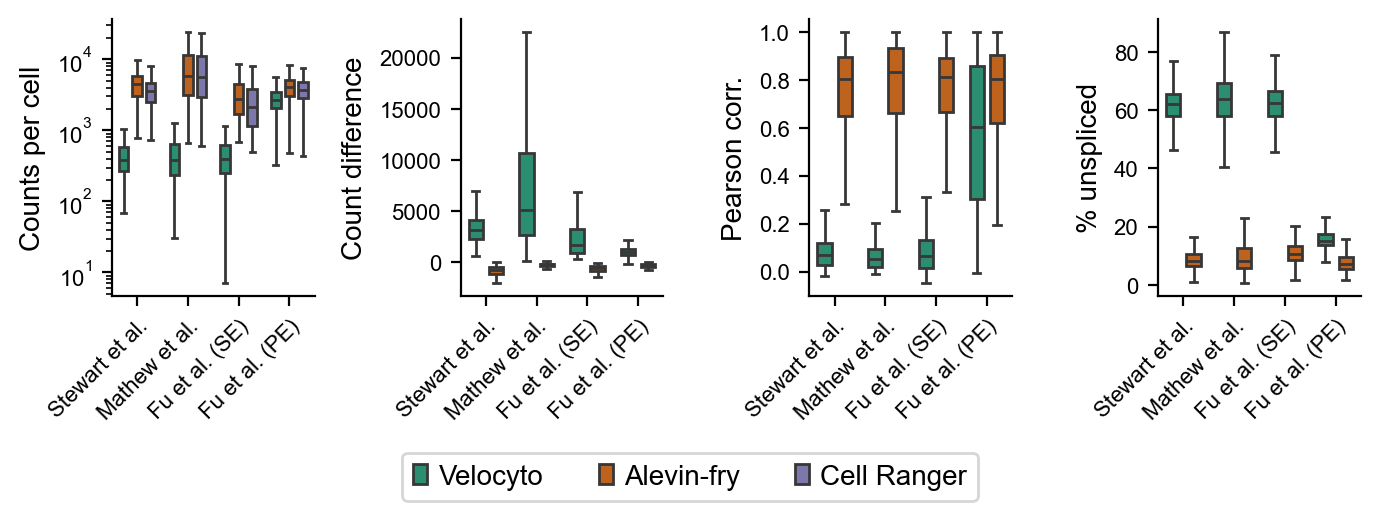

In [11]:
# Create figure
figsize = (figwidth, figwidth / (8 / 3))
fig, axs = plt.subplots(1, 4, figsize=figsize)  #, layout="tight")
axs = axs.ravel()

sns.boxplot(
    x="dataset",
    y="counts",
    hue="method",
    palette="Dark2",
    showfliers=False,
    gap=0.3,
    data=total_counts_df,
    ax=axs[0]
)
axs[0].set_ylabel("Counts per cell")
axs[0].set_yscale("log")

sns.boxplot(
    x="dataset",
    y="difference",
    hue="method",
    palette="Dark2",
    showfliers=False,
    gap=0.3,
    data=total_counts_diff,
    ax=axs[1]
)
axs[1].set_ylabel("Count difference")

sns.boxplot(
    x="dataset",
    y="pearsonr",
    hue="method",
    palette="Dark2",
    showfliers=False,
    gap=0.3,
    data=spliced_total_corrs,
    ax=axs[2]
)
axs[2].set_ylabel("Pearson corr.")

sns.boxplot(
    x="dataset",
    y="unspliced_ratio",
    hue="method",
    palette="Dark2",
    showfliers=False,
    gap=0.3,
    data=unspliced_ratios,
    ax=axs[3]
)
axs[3].set_ylabel("% unspliced")

for ax in axs:
    ax.set_xlabel("")
    ax.set_xticks(
        ticks=ax.get_xticks(),
        labels=[dataset_dict[lab.get_text()] for lab in ax.get_xticklabels()],
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    ax.legend().remove()

sns.despine(fig)

handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    [method_dict[l] for l in labels],
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    bbox_transform=fig.transFigure,
)

fig.tight_layout(
    rect=(0.0, (legend.get_tightbbox().y1 / fig.dpi) / figsize[1], 1.0, 1.0)
)

fig.savefig("figures/fig1")

## Figure 2

In [12]:
# Get overlapping genes
with gzip.open("data/2_overlapping_genes.gz", "rb") as f:
    overlapping_genes = pickle.load(f)

# Get correlations
corrs_overlapping = pd.read_parquet("data/2_corrs_overlapping.parquet.gzip")

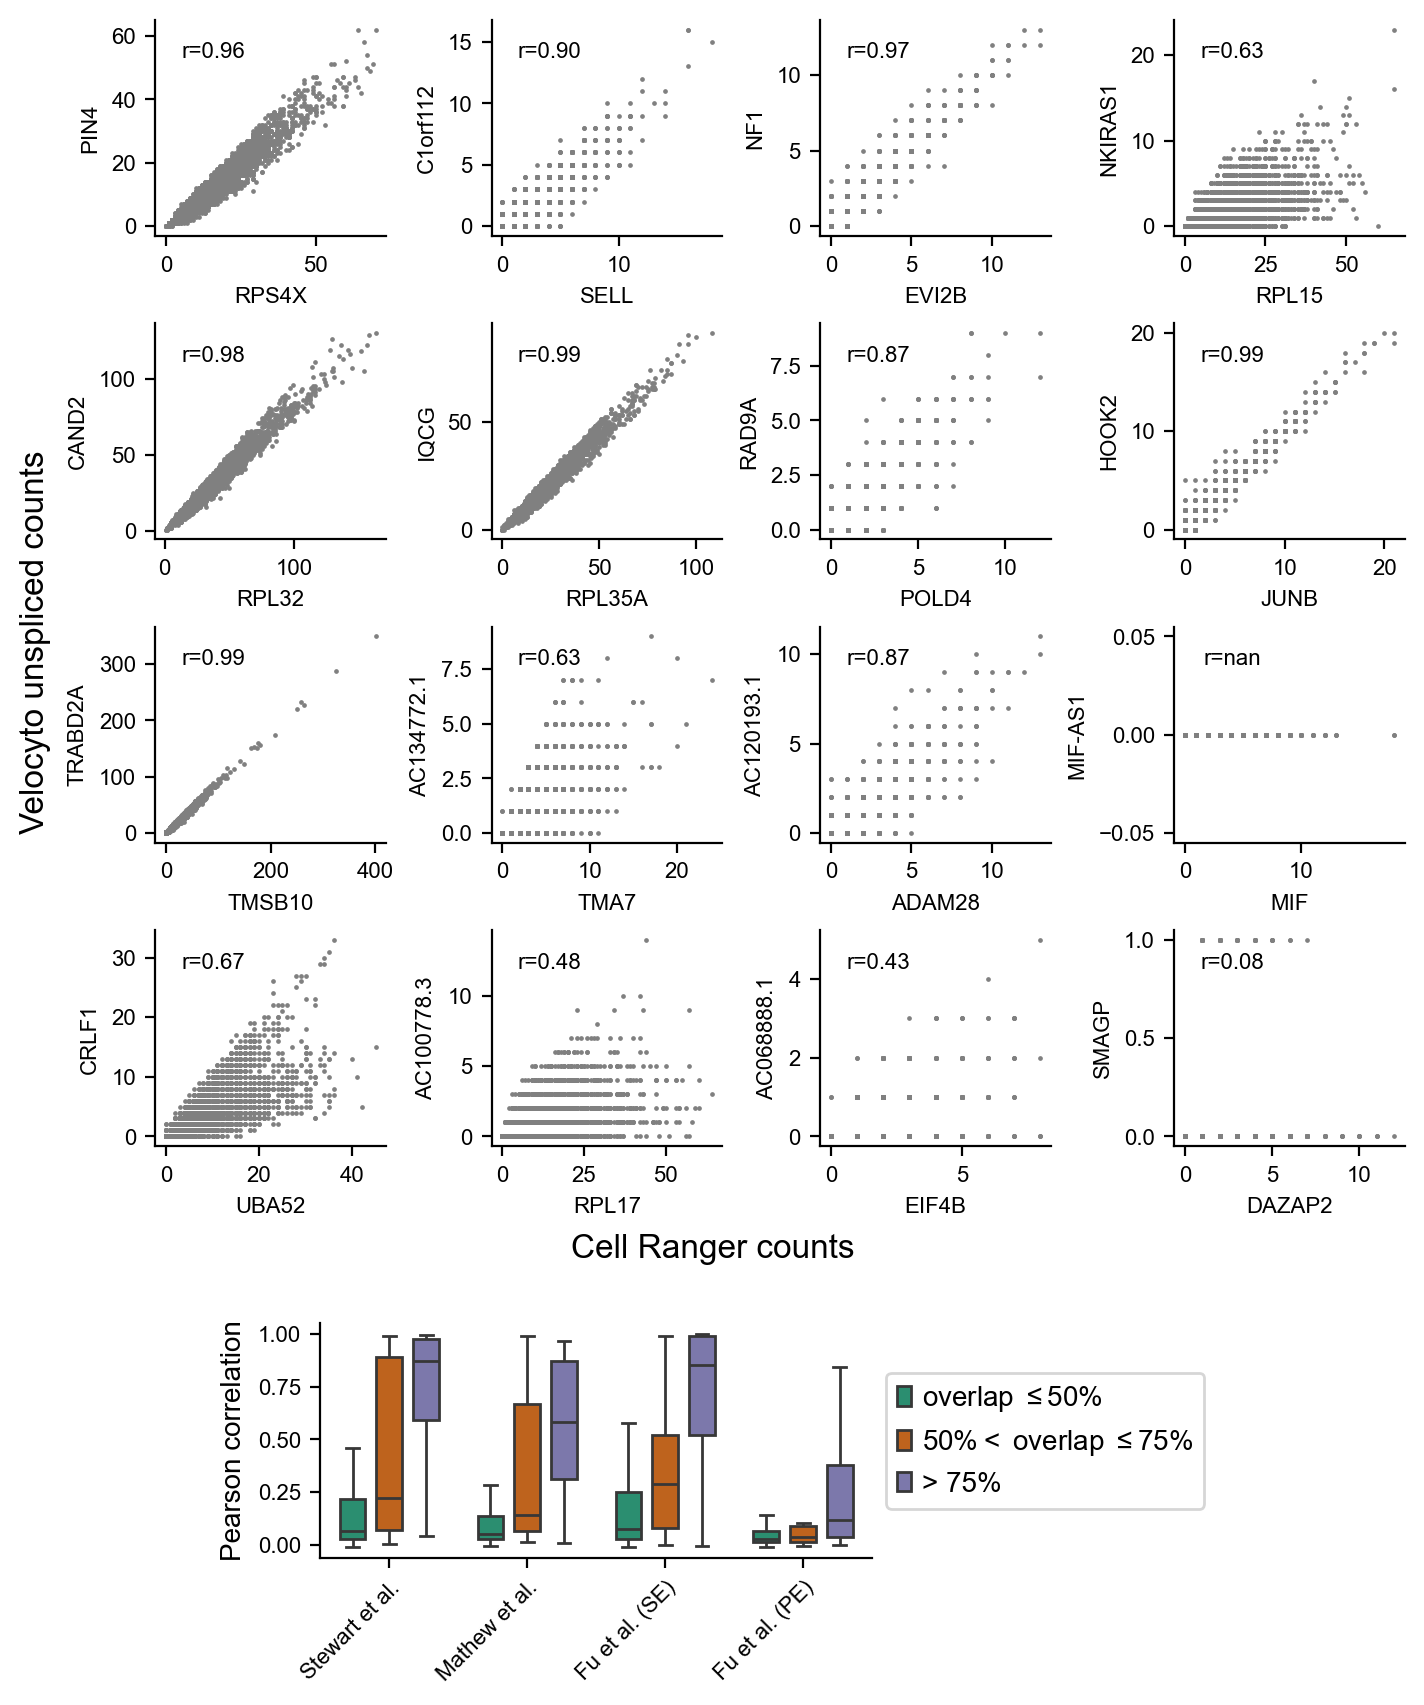

In [13]:
# Correlation of overlapping genes for Stewart et al.
fig = plt.figure(figsize=(figwidth, figwidth * 1.2), layout="constrained")

sub_figs = fig.subfigures(2, 1, height_ratios=(5, 1.5), hspace=0.05)
axs_top = sub_figs[0].subplots(4, 4).ravel()

for i, ax in enumerate(axs_top):
    gene_x = overlapping_genes["stewart"].index.get_level_values(0)[i]
    gene_y = overlapping_genes["stewart"].index.get_level_values(1)[i]
    x = adatas["stewart"]["velocyto"][:,gene_x].layers["counts"].toarray().ravel()
    y = adatas["stewart"]["velocyto"][:,gene_y].layers["unspliced_counts"].toarray().ravel()
    
    ax.scatter(x, y, s=0.5, c="grey", rasterized=True)
    ax.set_xlabel(gene_x, size=8)
    ax.set_ylabel(gene_y, size=8)
    
    corr, _ = stats.pearsonr(x, y)

    # display Pearson correlation and overlap
    ax.text(
        0.25,
        0.85,
        f"r={corr:.2f}",
        size=8,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

sub_figs[0].supxlabel("Cell Ranger counts")
sub_figs[0].supylabel("Velocyto unspliced counts")

axs_bottom = sub_figs[1].subplots(1, 3, width_ratios=[1, 3, 1])
sns.boxplot(
    x="dataset",
    y="pearsonr",
    hue="overlap",
    data=corrs_overlapping[corrs_overlapping.method == "velocyto"],
    gap=0.3,
    showfliers=False,
    palette="Dark2",
    ax=axs_bottom[1]
)
axs_bottom[1].legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=""
)
axs_bottom[1].set_xlabel("")
axs_bottom[1].set_ylabel("Pearson correlation")
axs_bottom[1].set_xticks(
    ticks=axs_bottom[1].get_xticks(),
    labels=[dataset_dict[lab.get_text()] for lab in axs_bottom[1].get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
axs_bottom[0].set_visible(False)
axs_bottom[2].set_visible(False)

sns.despine(fig)
fig.savefig("figures/fig2", dpi=300)

## Supplementary Figure 1

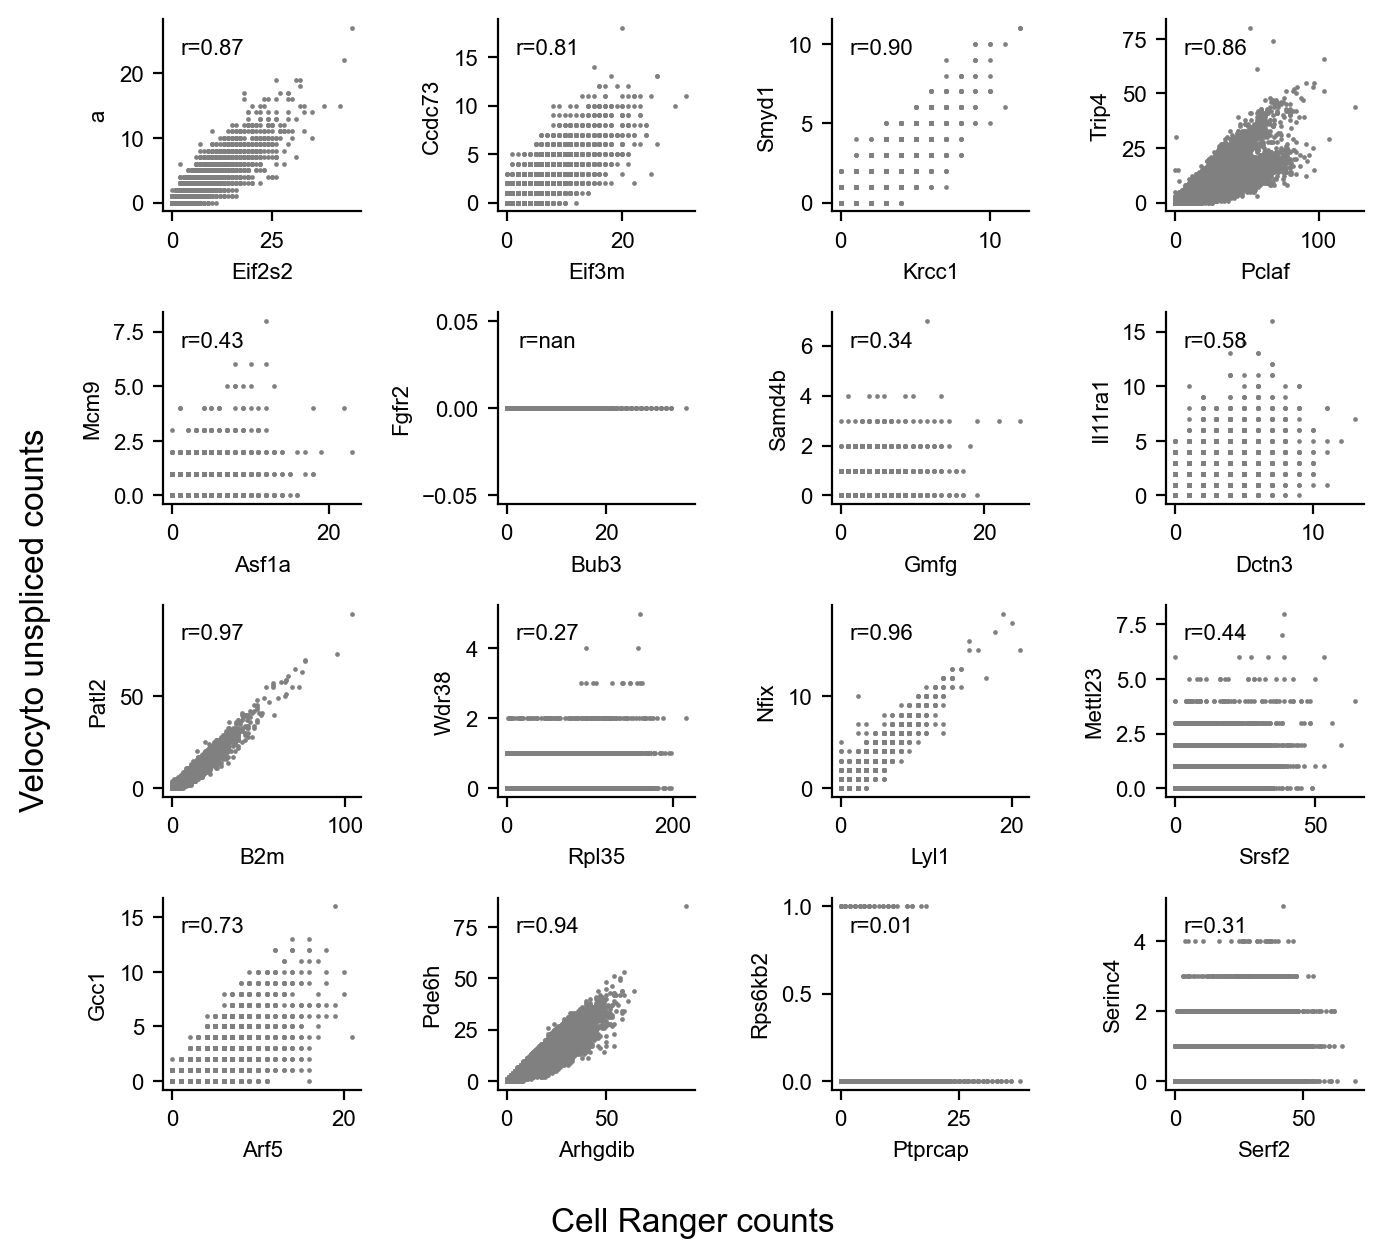

In [14]:
# Overlapping genes for Mathew et al.
fig, axs = plt.subplots(4, 4, figsize=(figwidth, figwidth * 0.9))
axs = axs.ravel()

for i, ax in enumerate(axs):
    gene_x = overlapping_genes["mathew"].index.get_level_values(0)[i]
    gene_y = overlapping_genes["mathew"].index.get_level_values(1)[i]
    x = adatas["mathew"]["velocyto"][:,gene_x].layers["counts"].toarray().ravel()
    y = adatas["mathew"]["velocyto"][:,gene_y].layers["unspliced_counts"].toarray().ravel()
    
    ax.scatter(x, y, s=0.5, c="grey", rasterized=True)
    ax.set_xlabel(gene_x, size=8)
    ax.set_ylabel(gene_y, size=8)
    
    corr, _ = stats.pearsonr(x, y)

    # display Pearson correlation and overlap
    ax.text(
        0.25,
        0.85,
        f"r={corr:.2f}",
        size=8,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

fig.supxlabel("Cell Ranger counts")
fig.supylabel("Velocyto unspliced counts")
sns.despine(fig)
fig.tight_layout()
fig.savefig("figures/suppfig1", dpi=300)

## Supplementary Figure 2

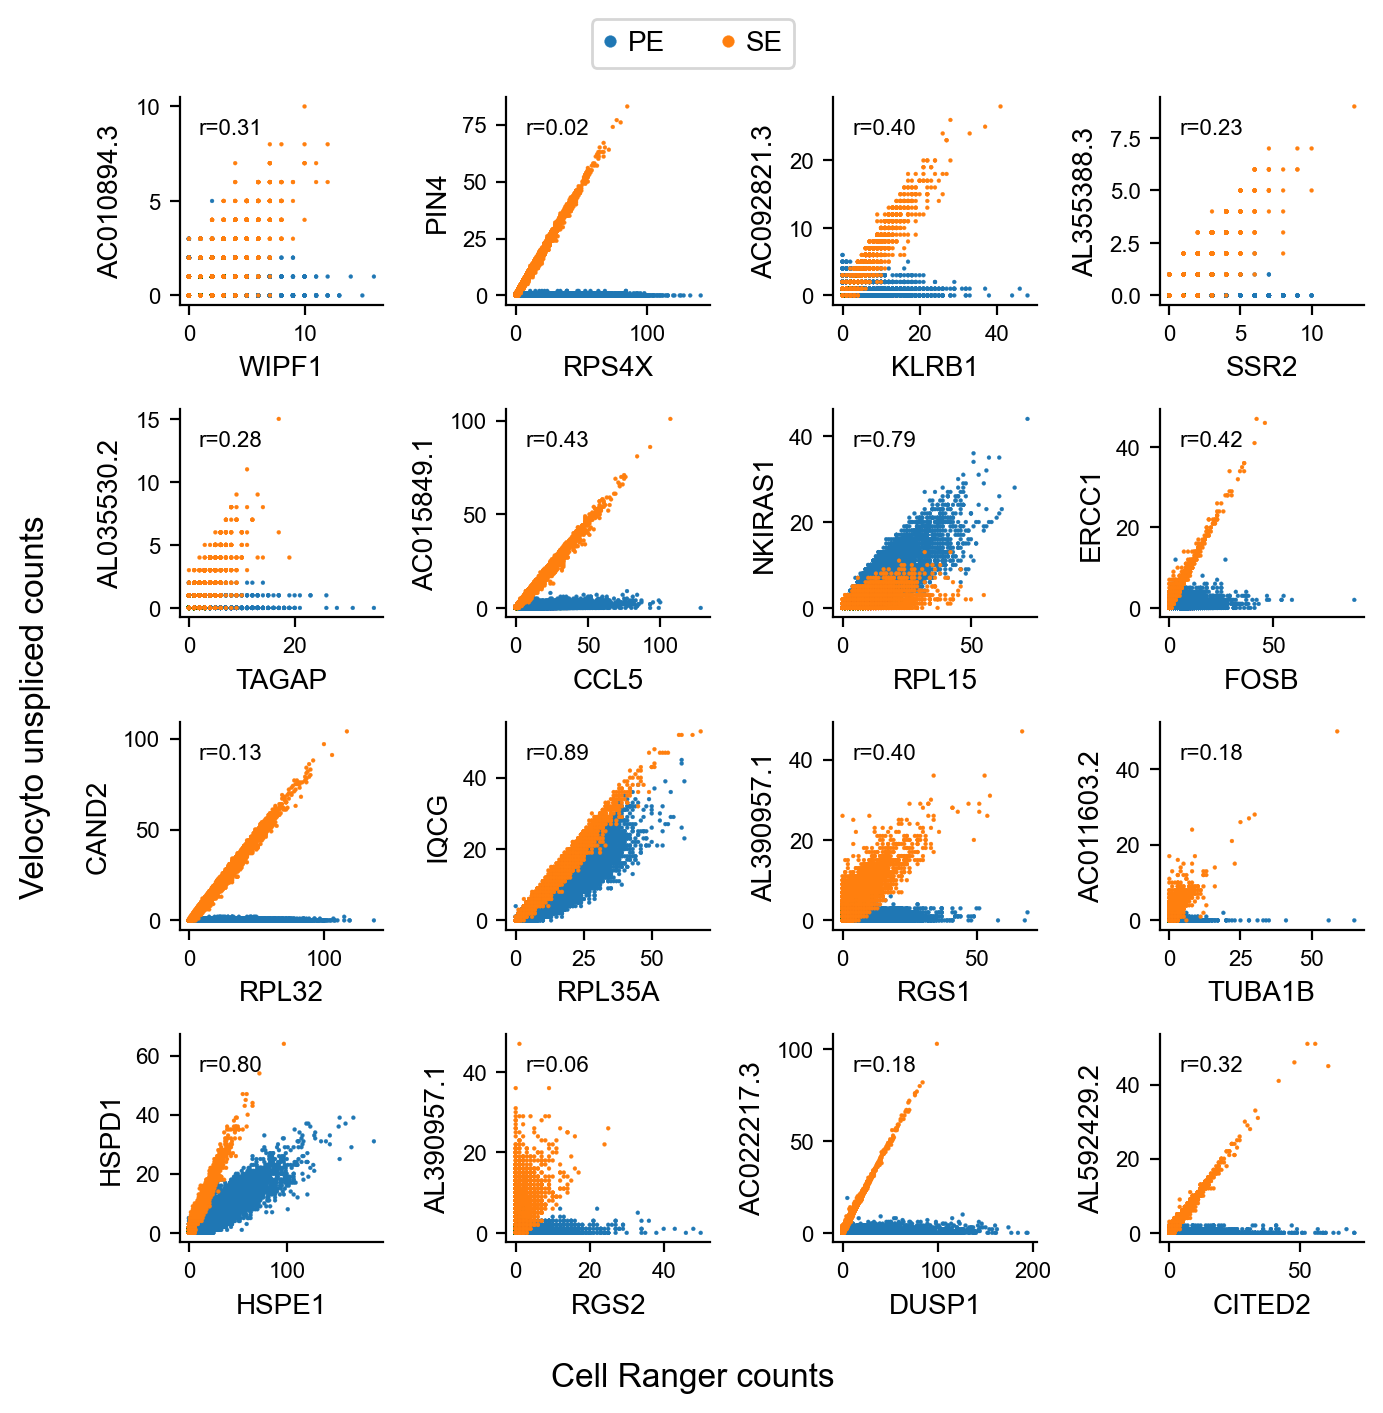

In [15]:
# Overlapping genes for Fu et al.
figsize = (figwidth, figwidth)
fig, axs = plt.subplots(4, 4, figsize=figsize)
axs = axs.ravel()

for i, ax in enumerate(axs):
    gene_x = overlapping_genes["fu"].index.get_level_values(0)[i]
    gene_y = overlapping_genes["fu"].index.get_level_values(1)[i]
    df = pd.concat(
        [
            pd.DataFrame(
                data={
                    "counts": adatas["fu_pe"]["velocyto"][:,gene_x].layers["counts"].toarray().ravel(),
                    "unspliced": adatas["fu_pe"]["velocyto"][:,gene_y].layers["unspliced_counts"].toarray().ravel(),
                    "alignment": "PE"
                }
            ),
            pd.DataFrame(
                data={
                    "counts": adatas["fu_se"]["velocyto"][:,gene_x].layers["counts"].toarray().ravel(),
                    "unspliced": adatas["fu_se"]["velocyto"][:,gene_y].layers["unspliced_counts"].toarray().ravel(),
                    "alignment": "SE"
                }
            )
            
        ]
    )
    
    sns.scatterplot(
        x="counts",
        y="unspliced",
        hue="alignment",
        data=df,
        s=2,
        edgecolor=None,
        rasterized=True,
        ax=ax
    )
    
    corr, _ = stats.pearsonr(df["counts"], df["unspliced"])

    # Display Pearson correlation
    ax.text(
        0.25,
        0.85,
        f"r={corr:.2f}",
        size=8,
        ha='center',
        va='center',
        transform=ax.transAxes
    )
    
    ax.set_xlabel(gene_x)
    ax.set_ylabel(gene_y)
    ax.legend().remove()

handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    markerscale=3,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.0),
    bbox_transform=fig.transFigure,
)

fig.supxlabel("Cell Ranger counts")
fig.supylabel("Velocyto unspliced counts")
sns.despine(fig)
fig.tight_layout(
    rect=(0.0, 0.0, 1.0, (legend.get_tightbbox().y0 / fig.dpi) / figsize[1])
)
fig.savefig("figures/suppfig2", dpi=300)

## Supplementary Figure 3

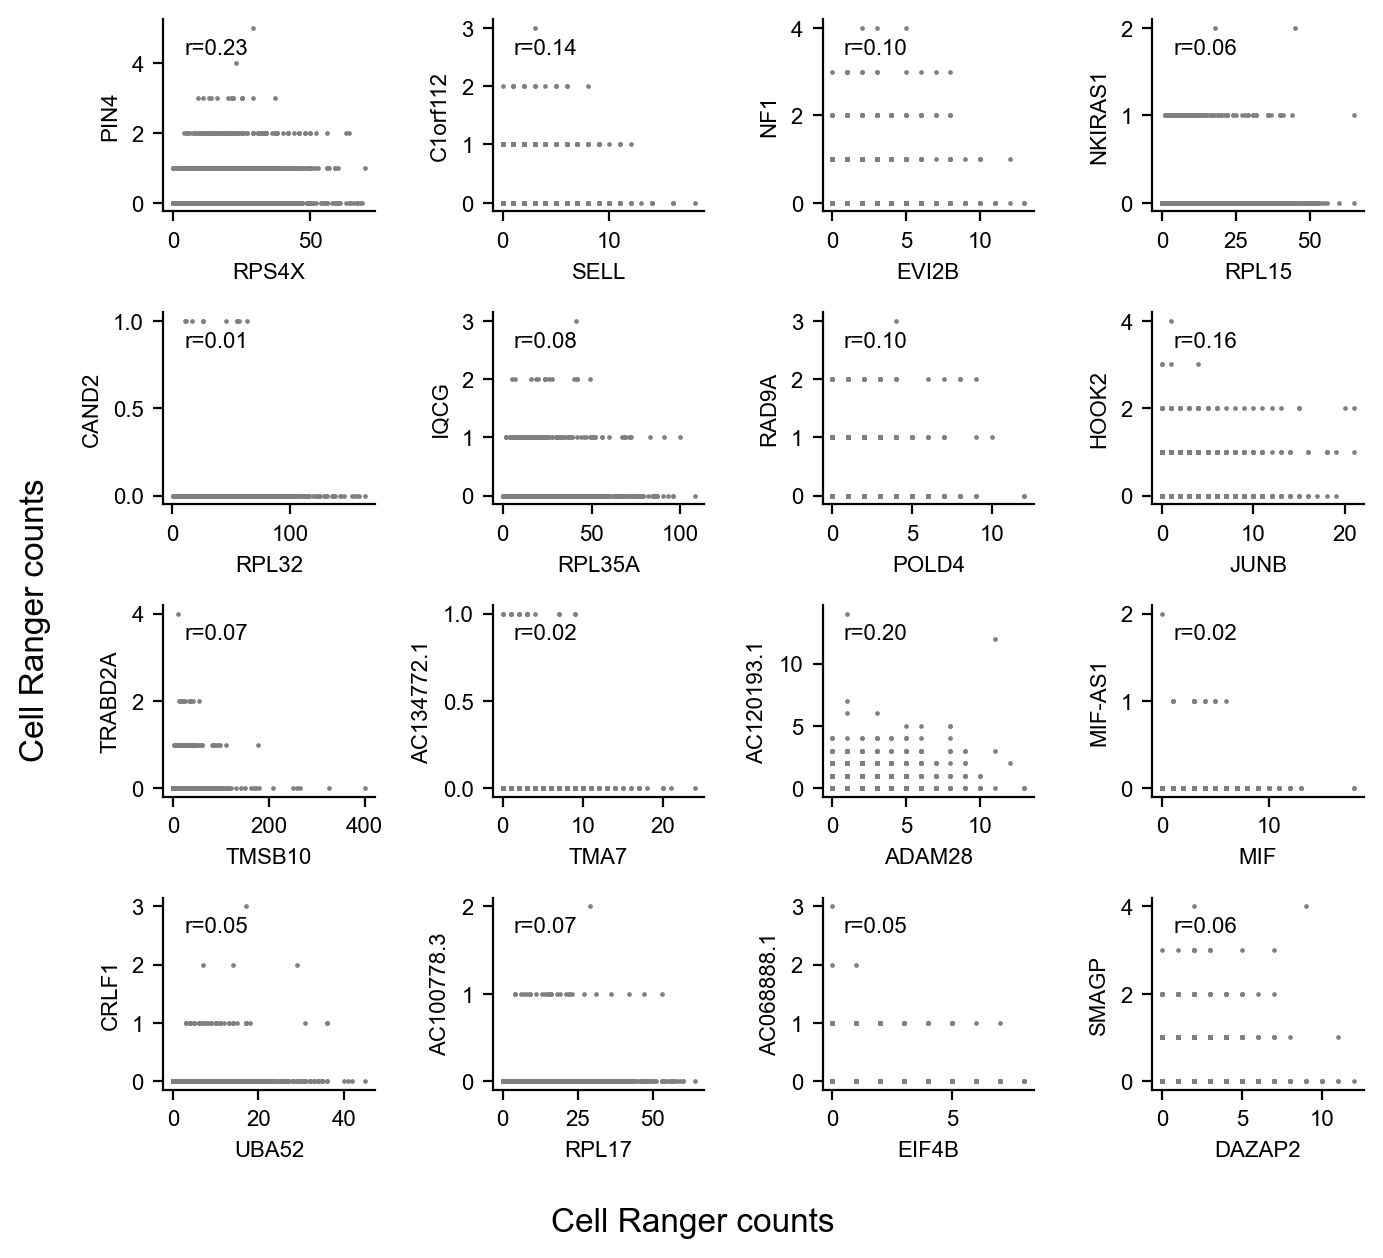

In [16]:
# Overlapping genes for Stewart: co-expression
fig, axs = plt.subplots(4, 4, figsize=(figwidth, figwidth * 0.9))
axs = axs.ravel()

for i, ax in enumerate(axs):
    gene_x = overlapping_genes["stewart"].index.get_level_values(0)[i]
    gene_y = overlapping_genes["stewart"].index.get_level_values(1)[i]
    x = adatas["stewart"]["velocyto"][:,gene_x].layers["counts"].toarray().ravel()
    y = adatas["stewart"]["velocyto"][:,gene_y].layers["counts"].toarray().ravel()
    
    ax.scatter(x, y, s=0.5, c="grey", rasterized=True)
    ax.set_xlabel(gene_x, size=8)
    ax.set_ylabel(gene_y, size=8)
    
    corr, _ = stats.pearsonr(x, y)

    # Display Pearson correlation
    ax.text(
        0.25,
        0.85,
        f"r={corr:.2f}",
        size=8,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

fig.supxlabel("Cell Ranger counts")
fig.supylabel("Cell Ranger counts")
sns.despine(fig)
fig.tight_layout()
fig.savefig("figures/suppfig3", dpi=300)

## Supplementary Figure 4

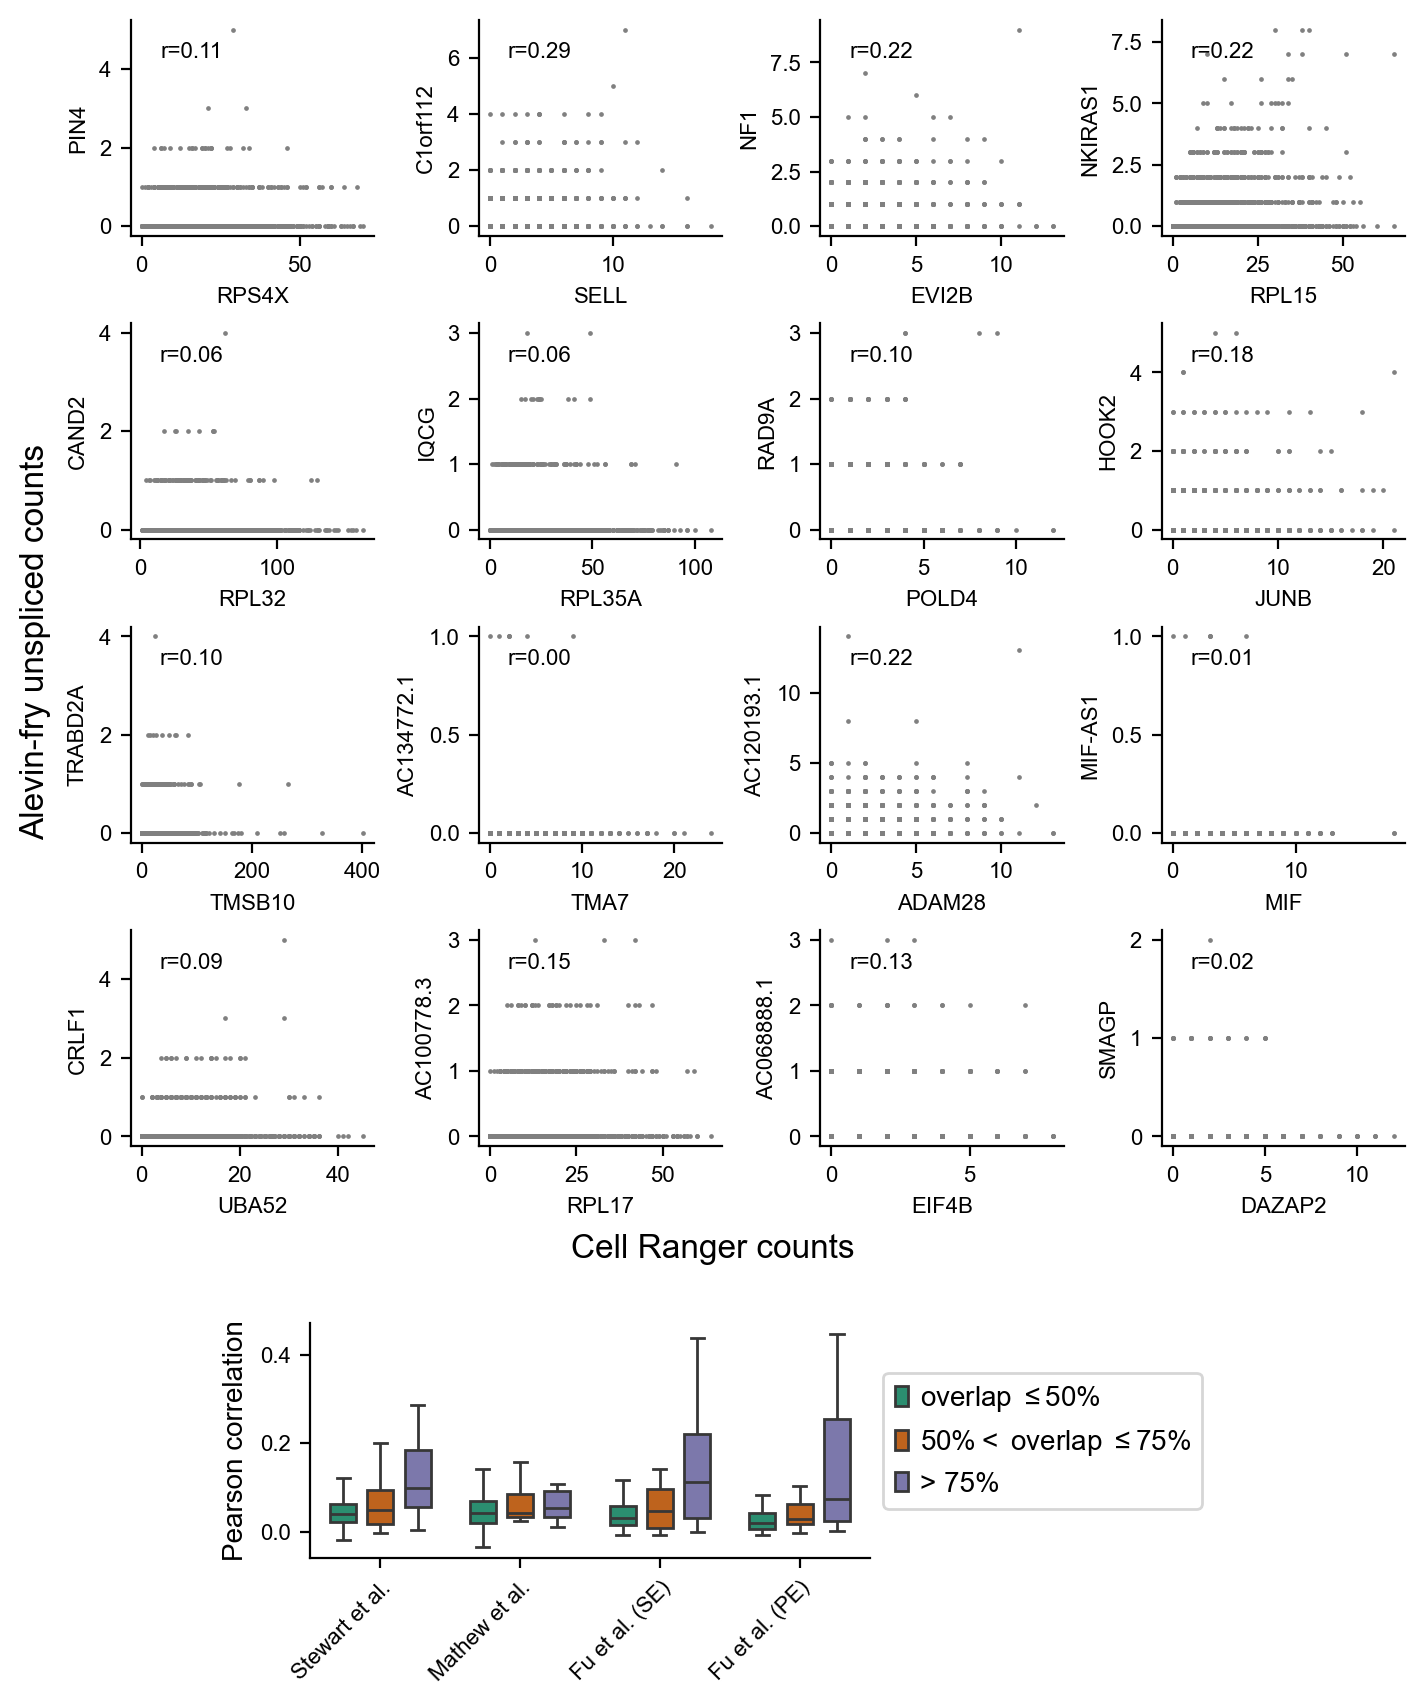

In [17]:
# Correlation of overlapping genes for Stewart et al: alevin
fig = plt.figure(figsize=(figwidth, figwidth * 1.2), layout="constrained")

sub_figs = fig.subfigures(2, 1, height_ratios=(5, 1.5), hspace=0.05)
axs_top = sub_figs[0].subplots(4, 4).ravel()

for i, ax in enumerate(axs_top):
    gene_x = overlapping_genes["stewart"].index.get_level_values(0)[i]
    gene_y = overlapping_genes["stewart"].index.get_level_values(1)[i]
    x = adatas["stewart"]["velocyto"][:,gene_x].layers["counts"].toarray().ravel()
    y = adatas["stewart"]["alevin"][:,gene_y].layers["unspliced_counts"].toarray().ravel()
    
    ax.scatter(x, y, s=0.5, c="grey", rasterized=True)
    ax.set_xlabel(gene_x, size=8)
    ax.set_ylabel(gene_y, size=8)
    
    corr, _ = stats.pearsonr(x, y)

    # display Pearson correlation and overlap
    ax.text(
        0.25,
        0.85,
        f"r={corr:.2f}",
        size=8,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

sub_figs[0].supxlabel("Cell Ranger counts")
sub_figs[0].supylabel("Alevin-fry unspliced counts")

axs_bottom = sub_figs[1].subplots(1, 3, width_ratios=[1, 3, 1])
sns.boxplot(
    x="dataset",
    y="pearsonr",
    hue="overlap",
    data=corrs_overlapping[corrs_overlapping.method == "alevin"],
    gap=0.3,
    showfliers=False,
    palette="Dark2",
    ax=axs_bottom[1]
)
axs_bottom[1].legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=""
)
axs_bottom[1].set_xlabel("")
axs_bottom[1].set_ylabel("Pearson correlation")
axs_bottom[1].set_xticks(
    ticks=axs_bottom[1].get_xticks(),
    labels=[dataset_dict[lab.get_text()] for lab in axs_bottom[1].get_xticklabels()],
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)
axs_bottom[0].set_visible(False)
axs_bottom[2].set_visible(False)

sns.despine(fig)
fig.savefig("figures/suppfig4", dpi=300)

## Supplementary Figure 5

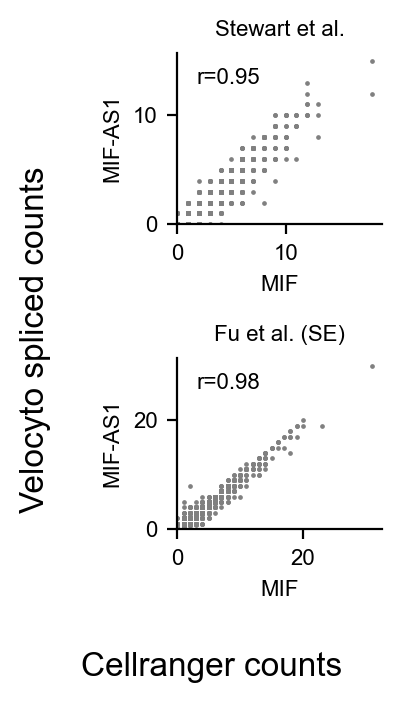

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(2, 3.5))

for i, dataset in enumerate(["stewart", "fu_se"]):
    x = adatas[dataset]["velocyto"][:,"MIF"].layers["counts"].toarray().ravel()
    y = adatas[dataset]["velocyto"][:,"MIF-AS1"].layers["spliced_counts"].toarray().ravel()

    axs[i].scatter(x, y, s=0.5, c='grey', rasterized=True)
    axs[i].set_xlabel("MIF", size=8)
    axs[i].set_ylabel("MIF-AS1", size=8)
    axs[i].set_xlim(left=0)
    axs[i].set_ylim(bottom=0)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    
    # calculate Pearson correlation
    corr, _ = stats.pearsonr(x, y)

    # display Pearson correlation
    axs[i].text(
        0.25,
        0.85,
        f"r={corr:.2f}",
        size=8,
        ha="center",
        va="center",
        transform=axs[i].transAxes
    )
    axs[i].set_title(dataset_dict[dataset], size=8)

fig.supxlabel("Cellranger counts", size=12)
fig.supylabel("Velocyto spliced counts", size=12)
sns.despine(fig)
fig.tight_layout()
fig.savefig("figures/suppfig5a", dpi=300)

## Figure 3

In [19]:
# Get velocity genes overlaps
velocity_genes_df = pd.read_parquet("data/3_velocity_genes.parquet.gz")

In [20]:
# Mark extreme quantiles
marker_genes = {"stewart": "TCL1A", "mathew": "Mki67", "fu": "TBX21"}

for dataset, sub_dict in adatas.items():
    if dataset.startswith("fu_"):
        continue
    lr = scv.core.LinearRegression(fit_intercept=False, percentile=[5, 95])
    n_obs, x, y = lr._trim_data(
        data=[
            sub_dict["velocyto"][:, marker_genes[dataset]].layers["Ms"],
            sub_dict["velocyto"][:, marker_genes[dataset]].layers["Mu"]
        ]
    )
    sub_dict["velocyto"].obs["extreme"] = False
    sub_dict["velocyto"].obs.loc[sub_dict["velocyto"].obs_names[(x + y).nonzero()[0]], "extreme"] = True
    
    n_obs, x, y = lr._trim_data(
        data=[
            sub_dict["alevin"][:, marker_genes[dataset]].layers["Ms"],
            sub_dict["alevin"][:, marker_genes[dataset]].layers["Mu"]
        ]
    )
    sub_dict["alevin"].obs["extreme"] = False
    sub_dict["alevin"].obs.loc[sub_dict["alevin"].obs_names[(x + y).nonzero()[0]], "extreme"] = True
    
    sub_dict["velocyto"].obs["extreme_quantile"] = "None"
    sub_dict["velocyto"].obs.loc[sub_dict["velocyto"].obs["extreme"], "extreme_quantile"] = "Velocyto"
    sub_dict["velocyto"].obs.loc[sub_dict["alevin"].obs["extreme"], "extreme_quantile"] = "Alevin-fry"
    sub_dict["velocyto"].obs.loc[(sub_dict["velocyto"].obs["extreme"] & sub_dict["alevin"].obs["extreme"]), "extreme_quantile"] = "Both"
    
    sub_dict["alevin"].obs["extreme_quantile"] = sub_dict["velocyto"].obs["extreme_quantile"].copy()
    
    del sub_dict["velocyto"].obs["extreme"], sub_dict["alevin"].obs["extreme"]

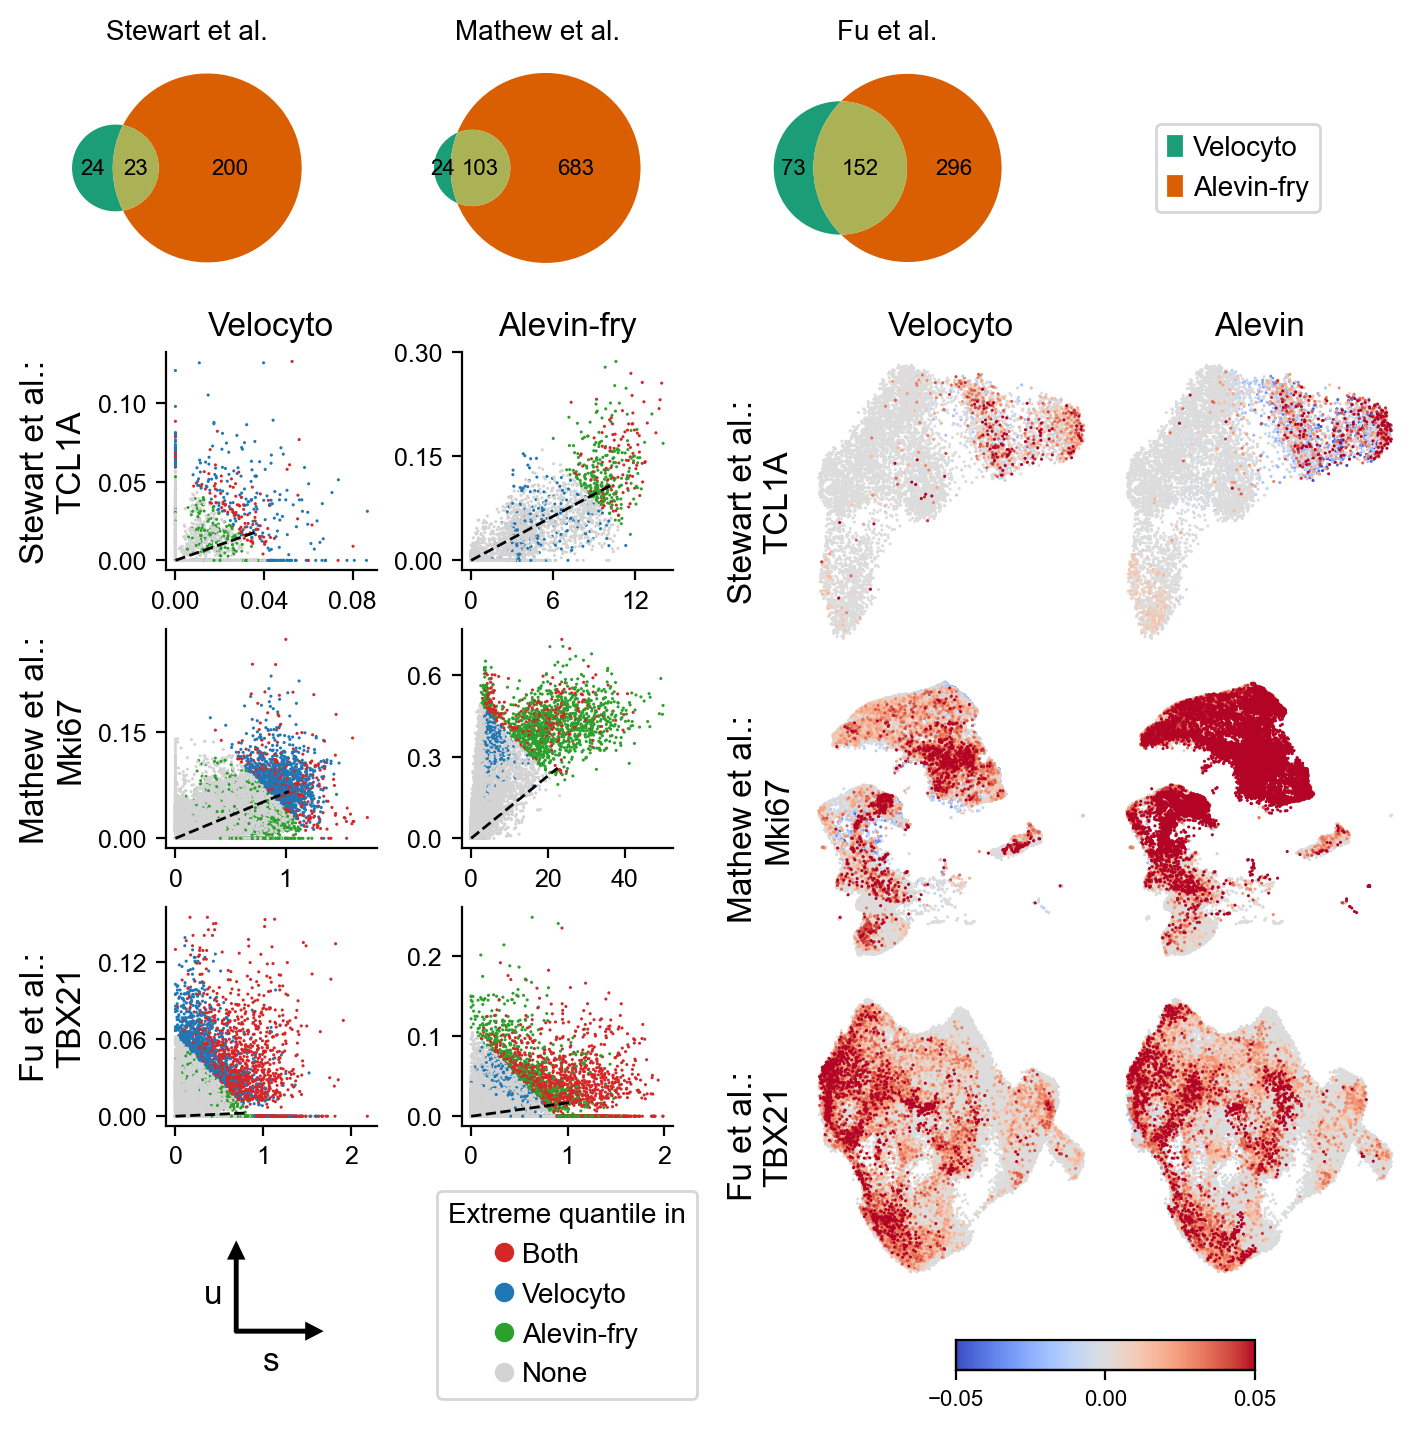

In [21]:
# Plot 
fig = plt.figure(figsize=(figwidth, figwidth), layout="constrained")

sub_figs = fig.subfigures(2, 1, height_ratios=(1, 4))

# Venn diagrams
axs_top = sub_figs[0].subplots(1, 4)
for i, ax in enumerate(axs_top[:-1]):
    row = velocity_genes_df.iloc[i, :]
    out = venn2(
        subsets=(row["velocyto"], row["alevin"], row["overlap"]),
        set_colors=[plt.get_cmap("Dark2")(0), plt.get_cmap("Dark2")(1)],
        set_labels=["", ""],
        alpha=1,
        ax=ax
    )
    for text in out.subset_labels:
        text.set_fontsize(8)
    ax.set_title(row.name)
    
legend = axs_top[-1].legend(
    handles=[
        mpatches.Patch(color=plt.get_cmap('Dark2')(0)),
        mpatches.Patch(color=plt.get_cmap('Dark2')(1))
    ],
    labels=["Velocyto", "Alevin-fry"],
    loc="center"
)
axs_top[-1].axis("off")

sub_figs_bottom = sub_figs[1].subfigures(1, 2)

# Phase plots
axs_left = sub_figs_bottom[0].subplots(4, 2)
palette = {"Both": "#d62728", "Velocyto": "#1f77b4", "Alevin-fry": "#2ca02c", "None": "lightgrey"}
for i, (dataset, marker) in enumerate(marker_genes.items()):
    scv.pl.scatter(
        adatas[dataset]["velocyto"],
        marker,
        color="extreme_quantile",
        palette=palette,
        ax=axs_left[i, 0],
        show=False,
        xlabel="",
        ylabel=f"{dataset_dict[dataset]}:\n{marker}",
        title="Velocyto" if i == 0 else "",
        size=5,
        fontsize=12
    )
    scv.pl.scatter(
        adatas[dataset]["alevin"],
        marker,
        color="extreme_quantile",
        palette=palette,
        ax=axs_left[i, 1],
        show=False,
        xlabel="",
        ylabel="",
        title="Alevin-fry" if i == 0 else "",
        size=5,
        fontsize=12
    )
    axs_left[i, 0].get_legend().remove()
    axs_left[i, 1].get_legend().remove()

axs_left[-1, -1].legend(
    handles=[
        mlines.Line2D([], [], color=c, marker="o", linestyle="None", label=lab)
        for lab, c in palette.items()
    ],
    title="Extreme quantile in",
    loc="center"
)
axs_left[-1, 0].arrow(0, 0, 0, 1, color="k", width=0.03, head_width=0.2, head_length=0.2)
axs_left[-1, 0].arrow(0, 0, 1, 0, color="k", width=0.03, head_width=0.2, head_length=0.2)
axs_left[-1, 0].text(-0.2, 0.5, "u", va="center", ha="right", fontsize=12)
axs_left[-1, 0].text(0.5, -0.2, "s", va="top", ha="center", fontsize=12)
axs_left[-1, 0].set_xlim(-1, 2)
axs_left[-1, 0].set_ylim(-1, 2)
axs_left[-1, 0].set_xticks([])
axs_left[-1, 0].set_yticks([])
axs_left[-1, -1].set_axis_off()

# Velocity UMAPs
vmin, vmax = -0.05, 0.05
axs_right = sub_figs_bottom[1].subplots(3, 2)
for i, (dataset, marker) in enumerate(marker_genes.items()):
    scv.pl.scatter(
        adatas[dataset]["velocyto"],
        layer="velocity",
        color=marker,
        colorbar=False,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        s=5,
        ax=axs_right[i, 0],
        show=False,
        title="Velocyto" if i == 0 else "",
        fontsize=12
    )
    axs_right[i, 0].set_ylabel(f"{dataset_dict[dataset]}:\n{marker}", fontsize=12)
    scv.pl.scatter(
        adatas[dataset]["alevin"],
        layer="velocity",
        color=marker,
        colorbar=False,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        s=5,
        ax=axs_right[i, 1],
        show=False,
        title="Alevin" if i == 0 else "",
        fontsize=12
    )
sub_figs_bottom[1].colorbar(
    mpl.cm.ScalarMappable(
        cmap=plt.get_cmap('coolwarm'),
        norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ),
    ticks=[vmin, 0, vmax],
    shrink=0.5,
    aspect=10,
    ax=axs_right,
    location="bottom"
)

sns.despine(fig)
sns.despine(ax=axs_left[-1, 0], left=True, bottom=True)
fig.savefig("figures/fig3")

## Figure 4

In [22]:
# Get data
cosine_sims = pd.read_parquet("data/4_cosine_sims.parquet.gzip")
velocity_corrs = pd.read_parquet("data/4_velocity_corrs.parquet.gzip")
wasserstein_dists = pd.read_parquet("data/4_wasserstein_dists.parquet.gzip")

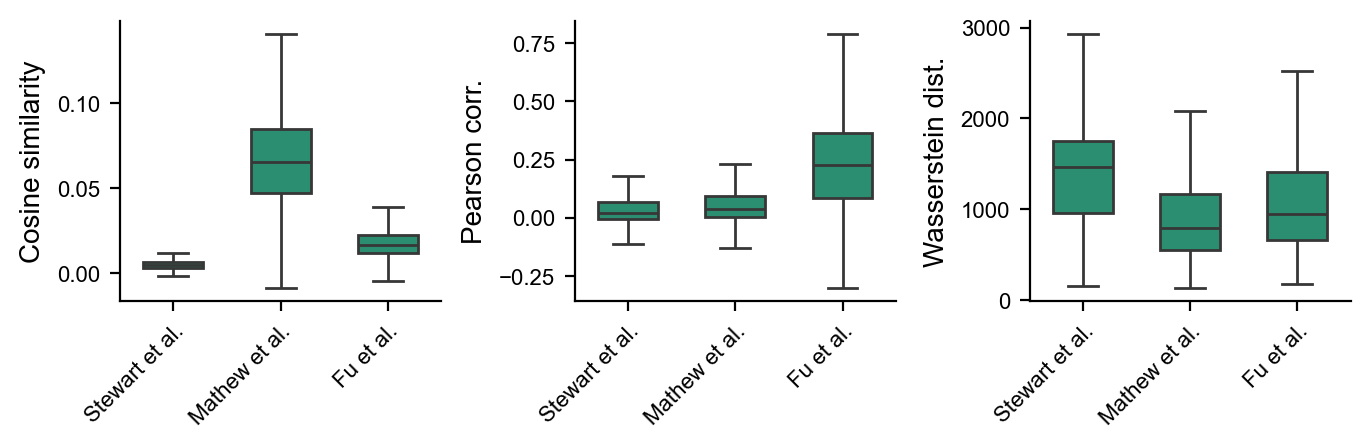

In [23]:
# Create figure
fig, axs = plt.subplots(1, 3, figsize=(figwidth, figwidth / 3), layout="tight")
axs = axs.ravel()

sns.boxplot(
    x="dataset",
    y="cosine_similarity",
    color=plt.get_cmap('Dark2')(0),
    showfliers=False,
    gap=0.3,
    data=cosine_sims,
    ax=axs[0]
)
axs[0].set_ylabel("Cosine similarity")

sns.boxplot(
    x="dataset",
    y="pearsonr",
    color=plt.get_cmap('Dark2')(0),
    showfliers=False,
    gap=0.3,
    data=velocity_corrs,
    ax=axs[1]
)
axs[1].set_ylabel("Pearson corr.")

sns.boxplot(
    x="dataset",
    y="wasserstein_distance",
    color=plt.get_cmap('Dark2')(0),
    showfliers=False,
    gap=0.3,
    data=wasserstein_dists,
    ax=axs[2]
)
axs[2].set_ylabel("Wasserstein dist.")

for ax in axs:
    ax.set_xlabel("")
    ax.set_xticks(
        ticks=ax.get_xticks(),
        labels=[dataset_dict[lab.get_text()] for lab in ax.get_xticklabels()],
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    ax.legend().remove()

sns.despine(fig)

fig.tight_layout()
fig.savefig("figures/fig4")

## Supplementary Figure 6

In [24]:
cluster_orders = {
    dataset: sub_dict["velocyto"].obs["cluster"].cat.categories
    for dataset, sub_dict in adatas.items()
}
cluster_orders["mathew"] = sorted(cluster_orders["mathew"], key=lambda x: (x[0], int(x[1:])))

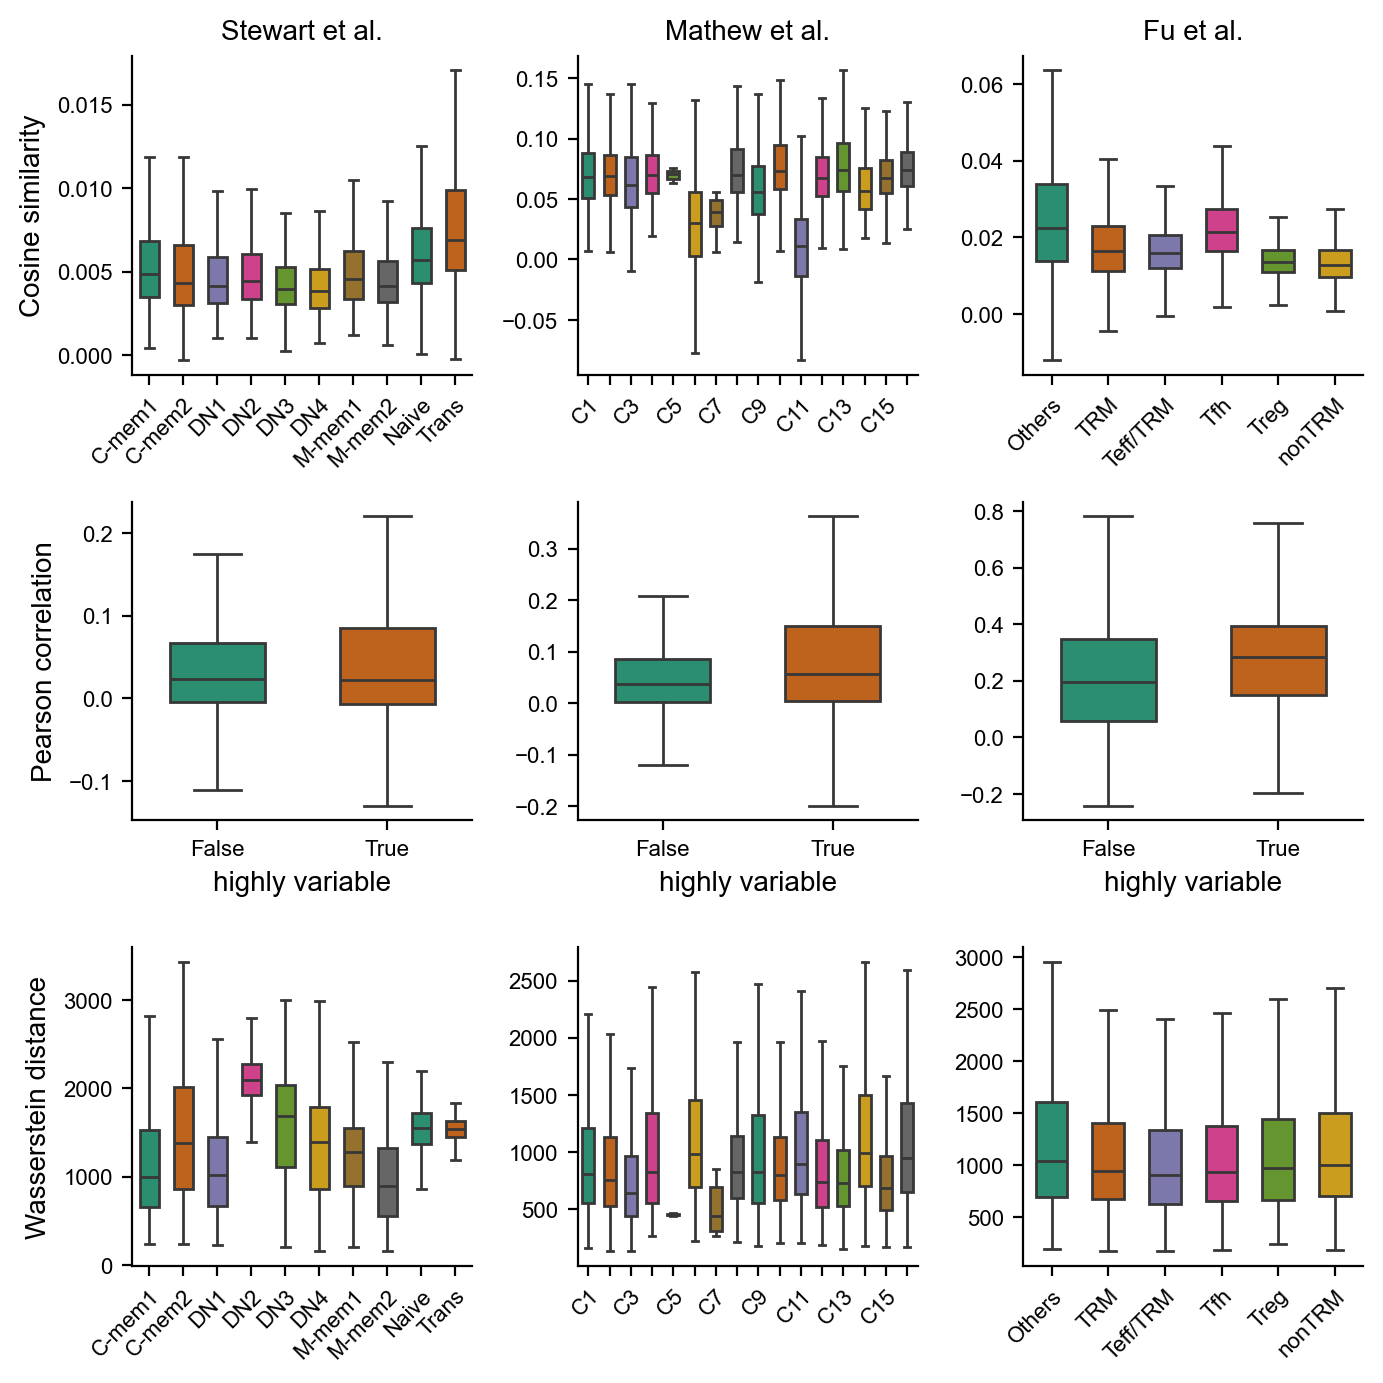

In [25]:
# Velocity comparisons per cluster etc.
fig, axs = plt.subplots(3, 3, figsize=(figwidth, figwidth))

for i, dataset in enumerate(cosine_sims["dataset"].unique()):
    sns.boxplot(
        x="cluster",
        y="cosine_similarity",
        order=cluster_orders[dataset],
        palette="Dark2",
        showfliers=False,
        gap=0.3,
        data=cosine_sims[cosine_sims["dataset"] == dataset],
        ax=axs[0, i]
    )
    axs[0, i].set_title(dataset_dict[dataset])
    axs[0, i].set_xlabel("")
    axs[0, i].set_ylabel("Cosine similarity" if i == 0 else "")
    xticklabels = axs[0, i].get_xticklabels()
    if dataset=="mathew":
        for j in range(len(xticklabels)):
            if j % 2 == 1:
                xticklabels[j] = ""
    axs[0, i].set_xticks(
        ticks=axs[0, i].get_xticks(),
        labels=xticklabels,
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )

for i, dataset in enumerate(velocity_corrs["dataset"].unique()):
    sns.boxplot(
        x="highly_variable",
        y="pearsonr",
        palette="Dark2",
        showfliers=False,
        gap=0.3,
        data=velocity_corrs[velocity_corrs["dataset"] == dataset],
        ax=axs[1, i]
    )
    axs[1, i].set_xlabel("highly variable")
    axs[1, i].set_ylabel("Pearson correlation" if i == 0 else "")
    axs[1, i].set_xticks(
        ticks=axs[1, i].get_xticks(),
        labels=["False", "True"]
    )

for i, dataset in enumerate(wasserstein_dists["dataset"].unique()):
    sns.boxplot(
        x="cluster",
        y="wasserstein_distance",
        order=cluster_orders[dataset],
        palette="Dark2",
        showfliers=False,
        gap=0.3,
        data=wasserstein_dists[wasserstein_dists["dataset"] == dataset],
        ax=axs[2, i]
    )
    axs[2, i].set_xlabel("")
    axs[2, i].set_ylabel("Wasserstein distance" if i == 0 else "")
    xticklabels = axs[2, i].get_xticklabels()
    if dataset=="mathew":
        for j in range(len(xticklabels)):
            if j % 2 == 1:
                xticklabels[j] = ""
    axs[2, i].set_xticks(
        ticks=axs[2, i].get_xticks(),
        labels=xticklabels,
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )

sns.despine(fig)
fig.tight_layout()
fig.savefig("figures/suppfig6")

## Supplementary Figure 7

In [26]:
# Read data
sign_changes = pd.read_parquet("data/s7_sign_changes.parquet.gzip")
cosine_sims_neighbors = pd.read_parquet("data/s7_cosine_sims_neighbors.parquet.gzip")
wasserstein_dists_union = pd.read_parquet("data/s7_wasserstein_dists_union.parquet.gzip")

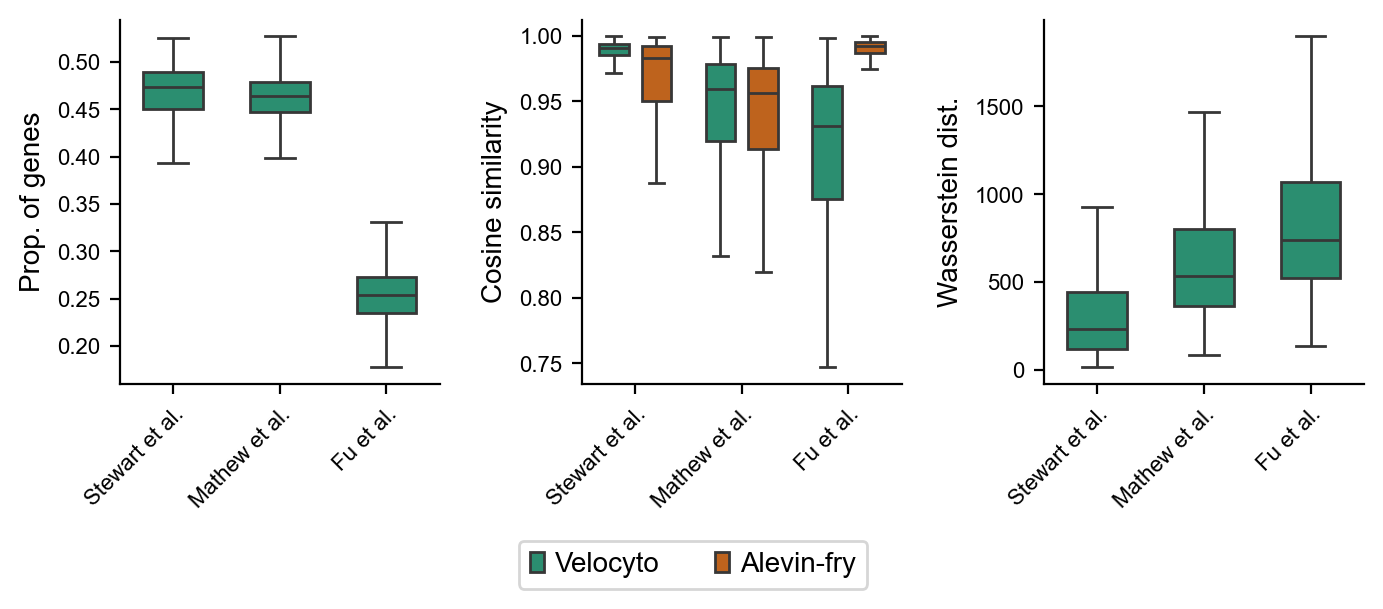

In [27]:
# Create figure
figsize = (figwidth, figwidth / 8 * 3.5)
fig, axs = plt.subplots(1, 3, figsize=figsize)

sns.boxplot(
    x="dataset",
    y="proportion",
    data=sign_changes,
    color=plt.get_cmap("Dark2")(0),
    gap=0.3,
    showfliers=False,
    ax=axs[0]
)
axs[0].set_ylabel("Prop. of genes")

sns.boxplot(
    x="dataset",
    y="cosine_similarity",
    hue="method",
    data=cosine_sims_neighbors,
    palette="Dark2",
    gap=0.3,
    showfliers=False,
    ax=axs[1]
)
axs[1].set_ylabel("Cosine similarity")
handles, labels = axs[1].get_legend_handles_labels()
legend = axs[1].legend(
    handles=handles,
    labels=[method_dict[lab] for lab in labels],
    title="",
    ncol=2,
    loc="lower center",
    bbox_to_anchor=(0.5, 0),
    bbox_transform=fig.transFigure
)

sns.boxplot(
    x="dataset",
    y="wasserstein_distance",
    data=wasserstein_dists_union,
    color=plt.get_cmap("Dark2")(0),
    gap=0.3,
    showfliers=False,
    ax=axs[2]
)
axs[2].set_ylabel("Wasserstein dist.")



for ax in axs:
    ax.set_xlabel("")
    ax.set_xticks(
        ticks=ax.get_xticks(),
        labels=[dataset_dict[lab.get_text()] for lab in ax.get_xticklabels()],
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )

sns.despine(fig)
fig.tight_layout(
    rect=(0.0, (legend.get_tightbbox().y1 / fig.dpi) / figsize[1], 1.0, 1.0)
)
fig.savefig("figures/suppfig7")

## PAGA

In [31]:
# Run PAGA for Stewart and Mathew
for dataset, sub_dict in adatas.items():
    if dataset in ["stewart", "mathew"]:
        for adata in sub_dict.values():
            if "paga" not in adata.uns_keys():
                scv.tl.paga(adata, groups="cluster")
    else:
        continue

computing terminal states
    identified 8 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connec

In [28]:
# Subset Fu dataset
adatas["fu_subset"] = {}
adatas["fu_subset"]["velocyto"] = adatas["fu"]["velocyto"][adatas["fu"]["velocyto"].obs["groups"].isin(['c01','c02', 'c03','c04','c07']),:].copy()
adatas["fu_subset"]["alevin"] = adatas["fu"]["alevin"][adatas["fu"]["alevin"].obs["groups"].isin(['c01','c02', 'c03','c04','c07']),:].copy()

In [29]:
# Calculate neighborhood of subsets
sc.pp.neighbors(adatas["fu_subset"]["velocyto"])

adatas["fu_subset"]["alevin"].obsp["distances"] = adatas["fu_subset"]["velocyto"][adatas["fu_subset"]["alevin"].obs_names, adatas["fu_subset"]["alevin"].var_names].obsp["distances"]
adatas["fu_subset"]["alevin"].obsp["connectivities"] = adatas["fu_subset"]["velocyto"][adatas["fu_subset"]["alevin"].obs_names, adatas["fu_subset"]["alevin"].var_names].obsp["connectivities"]
adatas["fu_subset"]["alevin"].uns["neighbors"] = adatas["fu_subset"]["velocyto"][adatas["fu_subset"]["alevin"].obs_names, adatas["fu_subset"]["alevin"].var_names].uns["neighbors"]

In [30]:
# Calculate velocities + PAGA of subsets
for adata in adatas["fu_subset"].values():
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode="stochastic", filter_genes=False)
    scv.tl.velocity_graph(adata)
    scv.tl.paga(adata, groups="groups") 

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:18) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:55) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)


  0%|          | 0/30877 [00:00<?, ?cells/s]

    finished (0:00:34) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:14) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:05) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:21) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:54) --> added 
    'velocity

  0%|          | 0/30877 [00:00<?, ?cells/s]

    finished (0:01:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:11) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:06) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


## Figure 5

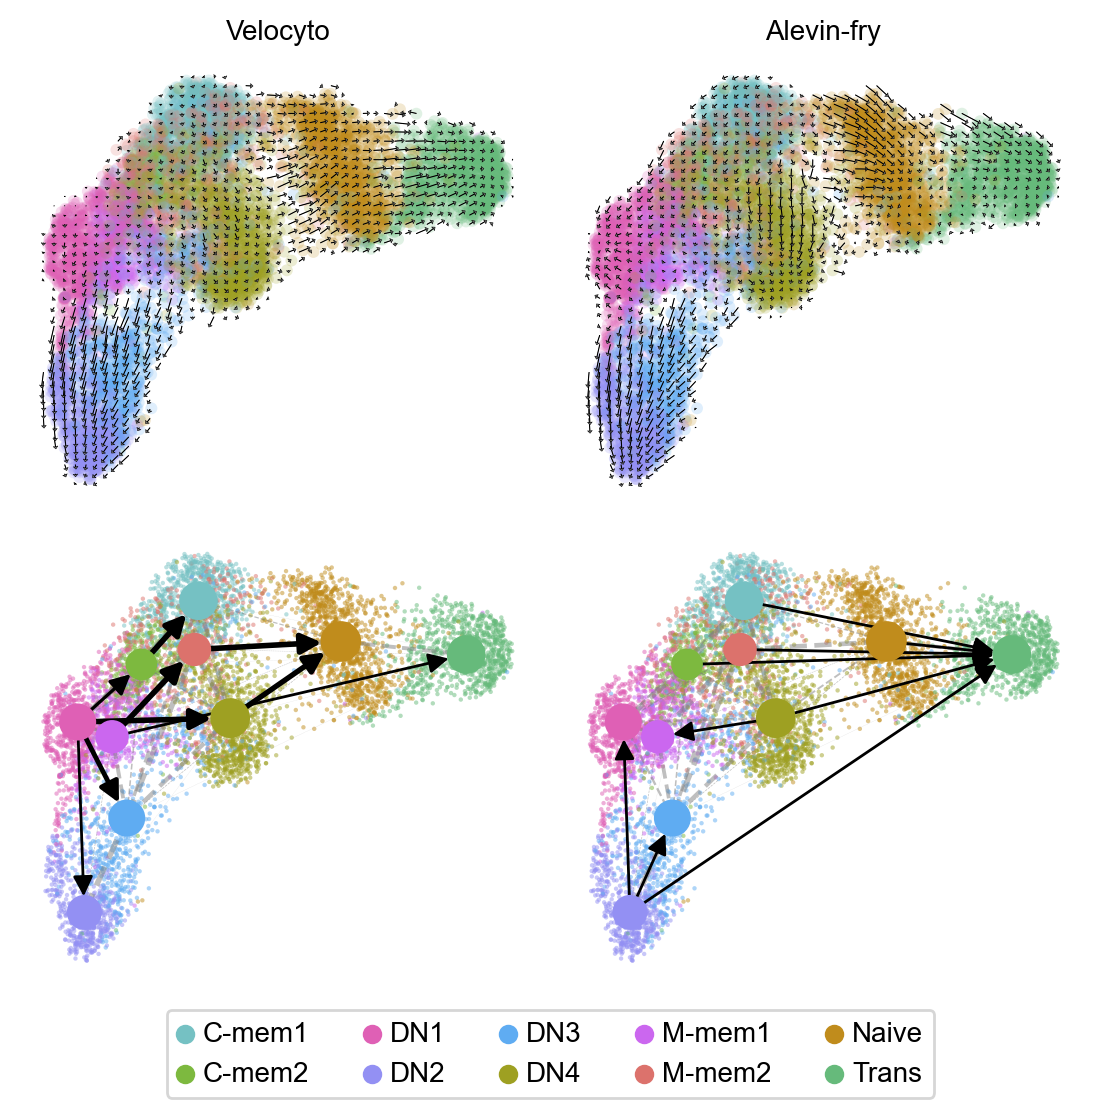

In [32]:
# Velocity embeddings and PAGA: Stewart
figsize=(figwidth * 0.8, figwidth * 0.8)
fig, axs = plt.subplots(2, 2, figsize=figsize, layout="tight")

scv.pl.velocity_embedding_grid(
    adatas["stewart"]["velocyto"],
    basis="umap",
    color="cluster",
    arrow_length=2, 
    density=0.9,
    arrow_size=(10,18,8),
    legend_loc="right margin",
    title="Velocyto",
    ax=axs[0, 0],
    show=False
)
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].get_legend().remove()

scv.pl.velocity_embedding_grid(
    adatas["stewart"]["alevin"],
    basis="umap",
    color="cluster",
    arrow_length=2, 
    density=0.9,
    arrow_size=(10,18,8),
    legend_loc="none",
    title="Alevin-fry",
    ax=axs[0, 1],
    show=False
)

sc.pl.umap(
    adatas["stewart"]["velocyto"],
    color="cluster",
    ax=axs[1, 0],
    show=False,
    size=10,
    alpha=0.5,
    legend_loc="none"
)
scv.pl.paga(
    adatas["stewart"]["velocyto"],
    basis="umap",
    color="cluster",
    size=10,
    alpha=0.7,
    min_edge_width=1,
    node_size_scale=1,
    legend_loc="none",
    title="",
    ax=axs[1, 0],
    show=False
)
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")

sc.pl.umap(
    adatas["stewart"]["alevin"],
    color="cluster",
    ax=axs[1, 1],
    show=False,
    size=10,
    alpha=0.5,
    legend_loc="none"
)
scv.pl.paga(
    adatas["stewart"]["alevin"],
    basis="umap",
    color="cluster",
    size=10,
    alpha=0.7,
    min_edge_width=1,
    node_size_scale=1,
    legend_loc="none",
    title="",
    ax=axs[1, 1],
    show=False
)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")

legend = fig.legend(
    handles,
    labels,
    ncol=5,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    bbox_transform=fig.transFigure,
)

fig.tight_layout(
    rect=(0.0, (legend.get_tightbbox().y1 / fig.dpi) / figsize[1], 1.0, 1.0)
)
fig.savefig("figures/fig5", dpi=300)

## Supplementary Figure 8

In [33]:
# Order cluster categories for Mathew data
adatas["mathew"]["velocyto"].obs["cluster"] = adatas["mathew"]["velocyto"].obs["cluster"].cat.set_categories(
    cluster_orders["mathew"]
)
adatas["mathew"]["alevin"].obs["cluster"] = adatas["mathew"]["alevin"].obs["cluster"].cat.set_categories(
    cluster_orders["mathew"]
)

In [34]:
if "cluster_colors" in adatas["mathew"]["velocyto"].uns_keys():
    del adatas["mathew"]["velocyto"].uns["cluster_colors"]
if "cluster_colors" in adatas["mathew"]["alevin"].uns_keys():
    del adatas["mathew"]["alevin"].uns["cluster_colors"]

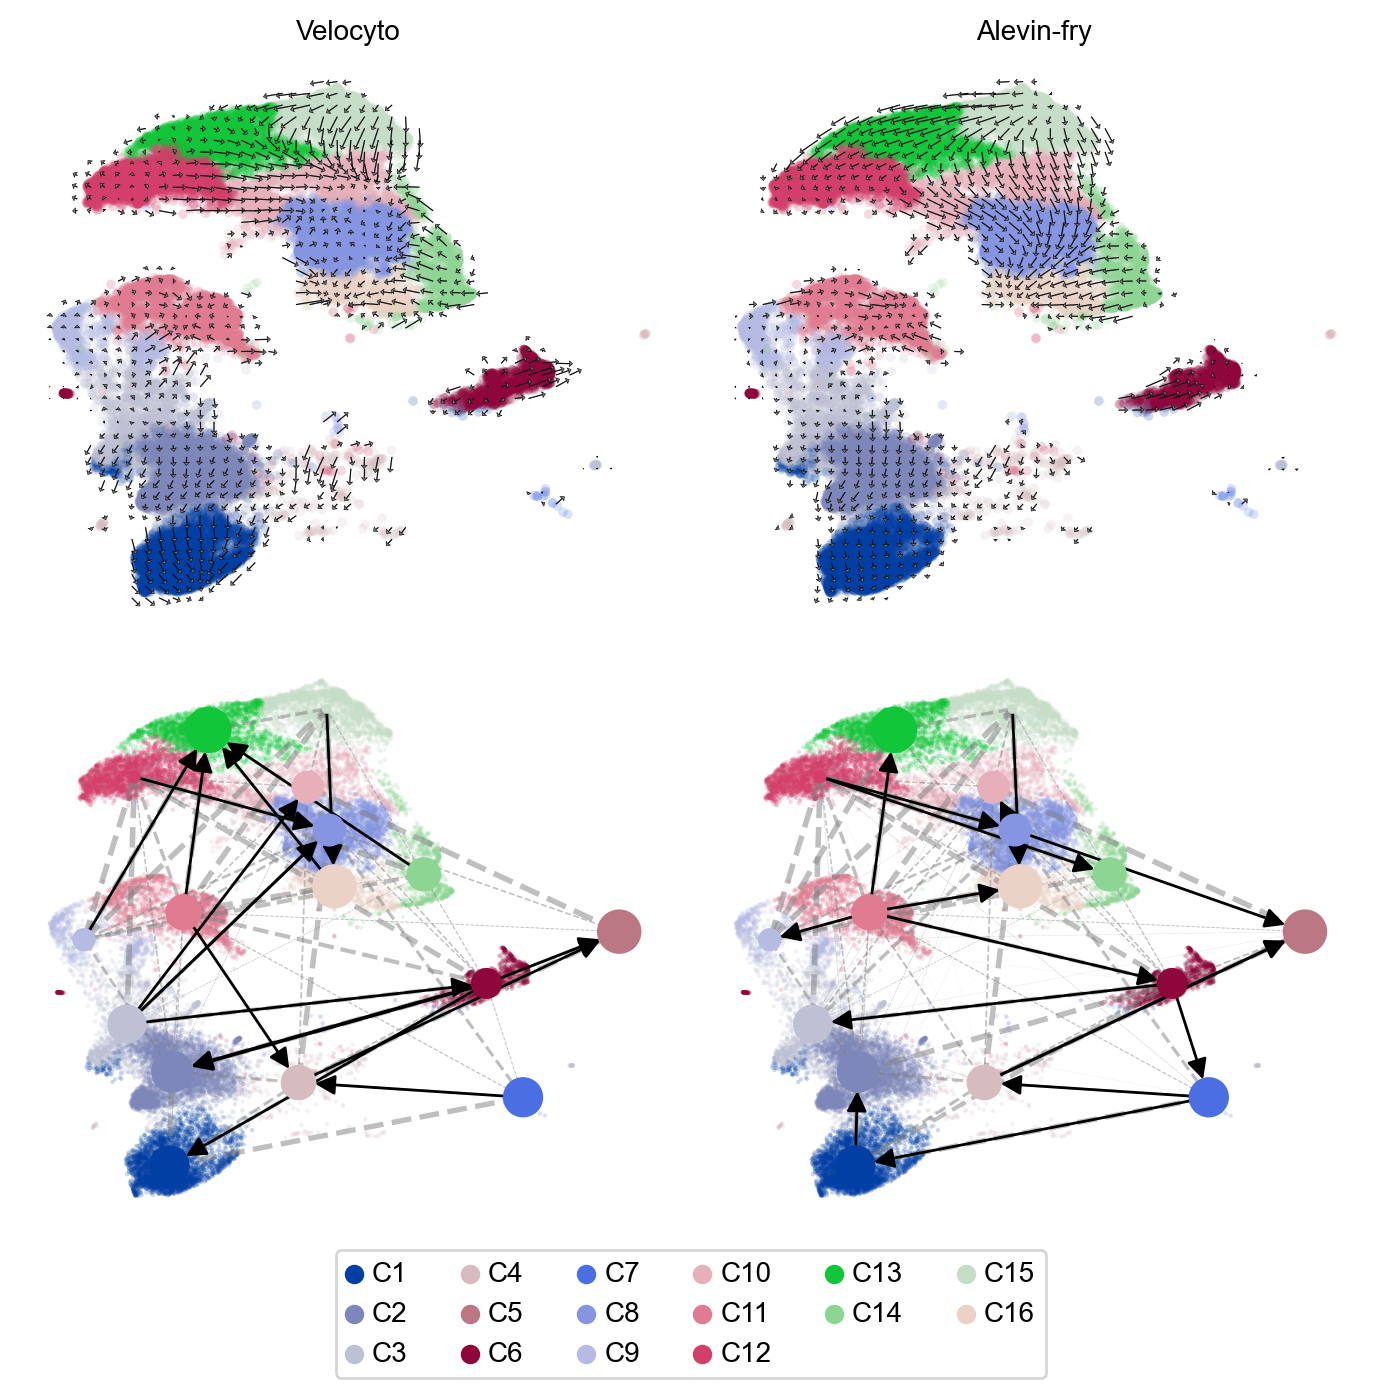

In [35]:
# Velocity embeddings and PAGA: Mathew
figsize=(figwidth, figwidth)
fig, axs = plt.subplots(2, 2, figsize=figsize, layout="tight")

scv.pl.velocity_embedding_grid(
    adatas["mathew"]["velocyto"],
    basis="umap",
    color="cluster",
    arrow_length=2, 
    density=0.9,
    arrow_size=(10,18,8),
    legend_loc="right margin",
    title="Velocyto",
    ax=axs[0, 0],
    show=False
)
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].get_legend().remove()

scv.pl.velocity_embedding_grid(
    adatas["mathew"]["alevin"],
    basis="umap",
    color="cluster",
    arrow_length=2, 
    density=0.9,
    arrow_size=(10,18,8),
    legend_loc="none",
    title="Alevin-fry",
    ax=axs[0, 1],
    show=False
)

sc.pl.umap(
    adatas["mathew"]["velocyto"],
    color="cluster",
    ax=axs[1, 0],
    show=False,
    size=10,
    alpha=0.2,
    legend_loc="none"
)
scv.pl.paga(
    adatas["mathew"]["velocyto"],
    basis="umap",
    color="cluster",
    size=10,
    alpha=0.7,
    min_edge_width=1,
    node_size_scale=1,
    legend_loc="none",
    title="",
    ax=axs[1, 0],
    show=False
)
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")

sc.pl.umap(
    adatas["mathew"]["alevin"],
    color="cluster",
    ax=axs[1, 1],
    show=False,
    size=10,
    alpha=0.2,
    legend_loc="none"
)
scv.pl.paga(
    adatas["mathew"]["alevin"],
    basis="umap",
    color="cluster",
    size=10,
    alpha=0.7,
    min_edge_width=1,
    node_size_scale=1,
    legend_loc="none",
    title="",
    ax=axs[1, 1],
    show=False
)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")

legend = fig.legend(
    handles,
    labels,
    ncol=6,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    bbox_transform=fig.transFigure,
)

fig.tight_layout(
    rect=(0.0, (legend.get_tightbbox().y1 / fig.dpi) / figsize[1], 1.0, 1.0)
)
fig.savefig("figures/suppfig8", dpi=300)

## Supplementary Figure 9

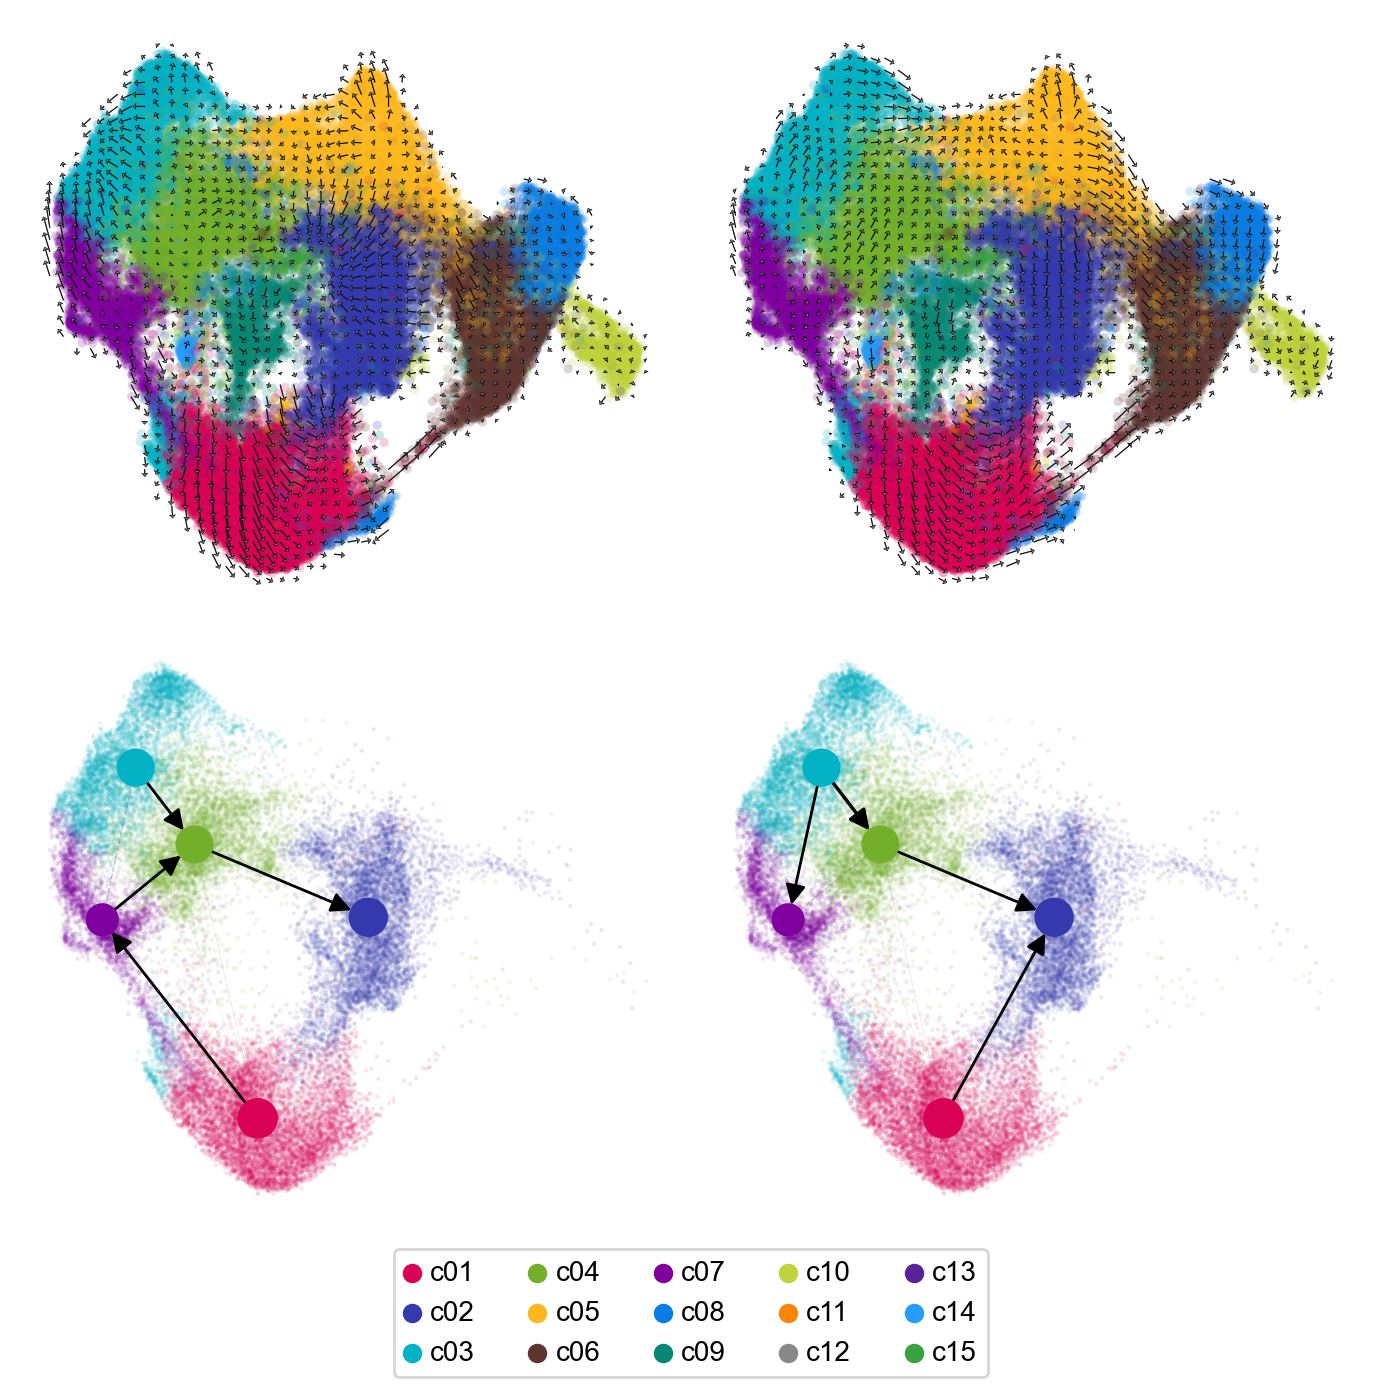

In [44]:
# Velocity embeddings and PAGA: Fu
figsize=(figwidth, figwidth)
fig, axs = plt.subplots(2, 2, figsize=figsize, layout="tight")

scv.pl.velocity_embedding_grid(
    adatas["fu"]["velocyto"],
    basis="umap",
    color="groups",
    arrow_length=2, 
    density=0.9,
    arrow_size=(10,18,8),
    legend_loc="right margin",
    title="",
    ax=axs[0, 0],
    show=False
)
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].get_legend().remove()

scv.pl.velocity_embedding_grid(
    adatas["fu"]["alevin"],
    basis="umap",
    color="groups",
    arrow_length=2, 
    density=0.9,
    arrow_size=(10,18,8),
    legend_loc="none",
    title="",
    ax=axs[0, 1],
    show=False
)

sc.pl.umap(
    adatas["fu_subset"]["velocyto"],
    color="groups",
    ax=axs[1, 0],
    show=False,
    size=10,
    alpha=0.1,
    legend_loc="none"
)
scv.pl.paga(
    adatas["fu_subset"]["velocyto"],
    basis="umap",
    color="groups",
    size=10,
    alpha=0.7,
    min_edge_width=1,
    node_size_scale=1,
    legend_loc="none",
    title="",
    ax=axs[1, 0],
    show=False
)
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")

sc.pl.umap(
    adatas["fu_subset"]["alevin"],
    color="groups",
    ax=axs[1, 1],
    show=False,
    size=10,
    alpha=0.1,
    legend_loc="none"
)
scv.pl.paga(
    adatas["fu_subset"]["alevin"],
    basis="umap",
    color="groups",
    size=10,
    alpha=0.7,
    min_edge_width=1,
    node_size_scale=1,
    legend_loc="none",
    title="",
    ax=axs[1, 1],
    show=False
)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")

legend = fig.legend(
    handles,
    labels,
    ncol=5,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    bbox_transform=fig.transFigure,
)

fig.tight_layout(
    rect=(0.0, (legend.get_tightbbox().y1 / fig.dpi) / figsize[1], 1.0, 1.0)
)
fig.savefig("figures/suppfig9", dpi=300)